In [10]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from catboost import CatBoostRegressor

In [11]:
# Load data
df = pd.read_csv(r'C:\Users\LEGION\Downloads\Ethereum_Historical_Data.csv', on_bad_lines='skip', low_memory=False)
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)
# Select the Close column as the dependent variable
df_Price = df[['Price']]
df_Price = df_Price.reset_index(drop=True)


In [12]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Price))
# Function to create dataset for time series
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Set time step
time_step = 10

In [13]:
# Split data into train and test sets
train_size = int(0.8 * len(data_scaled))
test_size = len(data_scaled) - train_size
train_data, test_data = data_scaled[0:train_size,:], data_scaled[train_size:len(data_scaled),:1]

# Create dataset for training and testing
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

# Reshape input for CatBoost
x_train = x_train.reshape(x_train.shape[0], time_step)
x_test = x_test.reshape(x_test.shape[0], time_step)

In [14]:
# Build the CatBoost model
model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=10, loss_function='RMSE', verbose=0)

# Train the model
model.fit(x_train, y_train)

In [15]:
# Predict the closing prices for the test data
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

# Evaluate the accuracy of the test data
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)

print(f"MAPE on Test dataset: {test_mape}")
print(f"RMSE on Test dataset: {test_rmse}")
print(f"MSE on Test dataset: {test_mse}")

MAPE on Test dataset: 0.024403981395770276
RMSE on Test dataset: 90.72593609703513
MSE on Test dataset: 8231.195480683302


Predicted ETH prices for the next 30 days:
[3825.5298859  3851.43310116 3875.08793768 3840.73258357 3840.48087426
 3898.89671548 3951.3999141  3937.72709962 3922.00692999 3932.10657151
 3954.34354964 3990.91897527 3984.97497614 3972.09030043 4007.63752932
 3977.09659852 3954.87232873 3961.53828242 3989.52082731 3953.21916332
 3957.61819979 3979.10913544 3959.37926846 3950.9549601  3959.37926846
 3959.37926846 3959.37926846 3959.37926846 3959.37926846 3959.37926846]


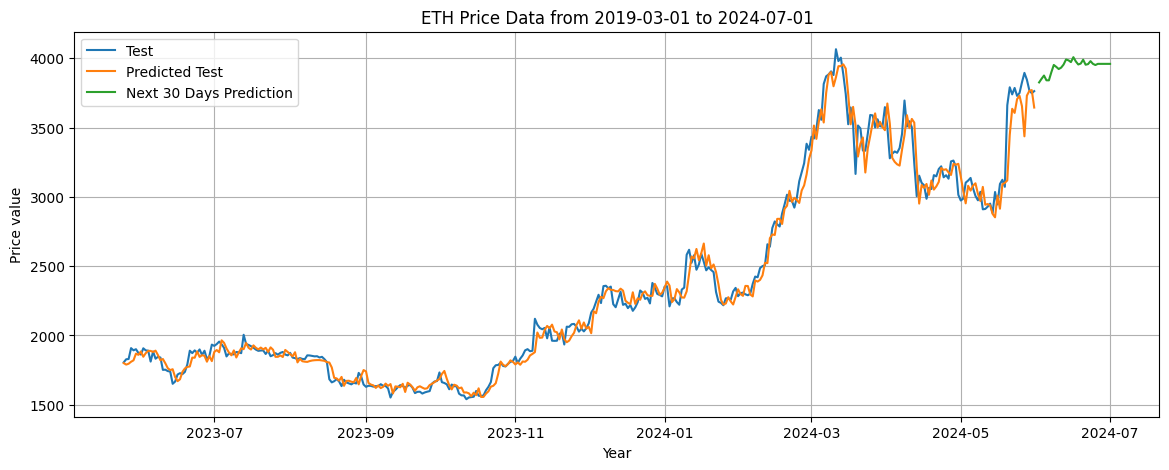

In [16]:
# Process of creating index to predict the next 30 days
last_index = len(df_Price) - 1

# Create an array of the last 'time_step' values from the dataset
x_input = data_scaled[last_index-time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Predict the closing prices for the next 30 days
lst_output = []
n_steps = time_step
i = 0
while(i < 30):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[-time_step:]).reshape(1, -1)
        yhat = model.predict(x_input)
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape(1, -1)
        yhat = model.predict(x_input)
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# Inverse transform the predicted values
y_next_30_days = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))

# Print the predicted closing prices for the next 30 days
print('Predicted ETH prices for the next 30 days:')
print(y_next_30_days.flatten())

# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)
# Create a list of indices starting from the next date for 30 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

# Plotting
plt.figure(figsize=(14, 5))
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_test)], y_test, label='Test')
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_pred)], y_pred, label='Predicted Test')
plt.plot(index_next_30_days, y_next_30_days, label='Next 30 Days Prediction')
plt.legend()
plt.grid()
plt.title(f"ETH Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Year")
plt.ylabel("Price value")
plt.show()

Predicted XRP prices for the next 60 days:
[3825.5298859  3851.43310116 3875.08793768 3840.73258357 3840.48087426
 3898.89671548 3951.3999141  3937.72709962 3922.00692999 3932.10657151
 3954.34354964 3990.91897527 3984.97497614 3972.09030043 4007.63752932
 3977.09659852 3954.87232873 3961.53828242 3989.52082731 3953.21916332
 3957.61819979 3979.10913544 3959.37926846 3950.9549601  3959.37926846
 3959.37926846 3959.37926846 3959.37926846 3959.37926846 3959.37926846
 3959.37926846 3959.37926846 3959.37926846 3959.37926846 3959.37926846
 3959.37926846 3959.37926846 3959.37926846 3959.37926846 3959.37926846
 3959.37926846 3959.37926846 3959.37926846 3959.37926846 3959.37926846
 3959.37926846 3959.37926846 3959.37926846 3959.37926846 3959.37926846
 3959.37926846 3959.37926846 3959.37926846 3959.37926846 3959.37926846
 3959.37926846 3959.37926846 3959.37926846 3959.37926846 3959.37926846]


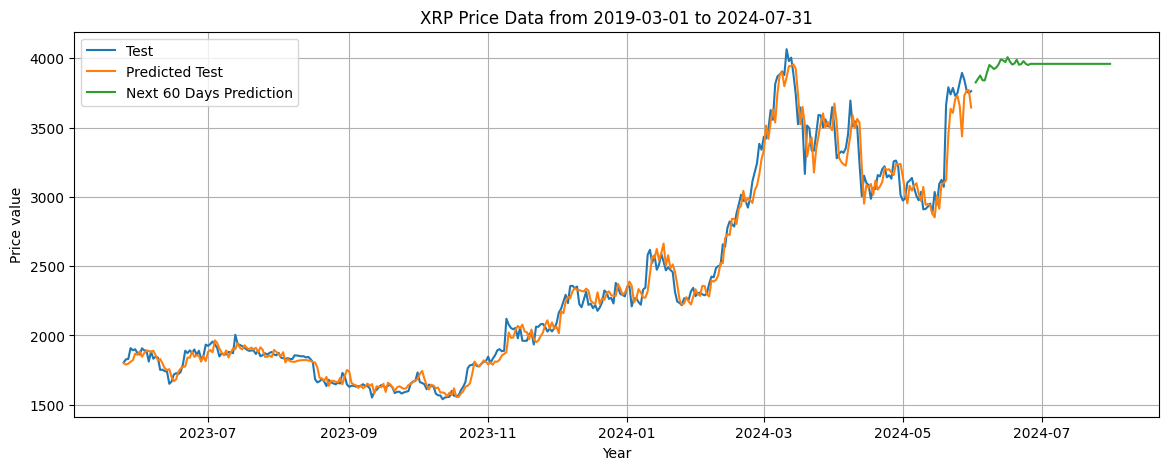

In [17]:
# Process of creating index to predict the next 60 days
last_index = len(df_Price) - 1

# Create an array of the last 'time_step' values from the dataset
x_input = data_scaled[last_index-time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Predict the closing prices for the next 60 days
lst_output = []
n_steps = time_step
i = 0
while(i < 60):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[-time_step:]).reshape(1, -1)
        yhat = model.predict(x_input)
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape(1, -1)
        yhat = model.predict(x_input)
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# Inverse transform the predicted values
y_next_60_days = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))

# Print the predicted closing prices for the next 60 days
print('Predicted XRP prices for the next 60 days:')
print(y_next_60_days.flatten())

# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)
# Create a list of indices starting from the next date for 60 days
index_next_60_days = pd.date_range(start=next_date, periods=60).tolist()

# Plotting
plt.figure(figsize=(14, 5))
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_test)], y_test, label='Test')
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_pred)], y_pred, label='Predicted Test')
plt.plot(index_next_60_days, y_next_60_days, label='Next 60 Days Prediction')
plt.legend()
plt.grid()
plt.title(f"XRP Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_60_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Year")
plt.ylabel("Price value")
plt.show()

Predicted ETH prices for the next 60 days:
[3825.5298859  3851.43310116 3875.08793768 3840.73258357 3840.48087426
 3898.89671548 3951.3999141  3937.72709962 3922.00692999 3932.10657151
 3954.34354964 3990.91897527 3984.97497614 3972.09030043 4007.63752932
 3977.09659852 3954.87232873 3961.53828242 3989.52082731 3953.21916332
 3957.61819979 3979.10913544 3959.37926846 3950.9549601  3959.37926846
 3959.37926846 3959.37926846 3959.37926846 3959.37926846 3959.37926846
 3959.37926846 3959.37926846 3959.37926846 3959.37926846 3959.37926846
 3959.37926846 3959.37926846 3959.37926846 3959.37926846 3959.37926846
 3959.37926846 3959.37926846 3959.37926846 3959.37926846 3959.37926846
 3959.37926846 3959.37926846 3959.37926846 3959.37926846 3959.37926846
 3959.37926846 3959.37926846 3959.37926846 3959.37926846 3959.37926846
 3959.37926846 3959.37926846 3959.37926846 3959.37926846 3959.37926846
 3959.37926846 3959.37926846 3959.37926846 3959.37926846 3959.37926846
 3959.37926846 3959.37926846 3959.

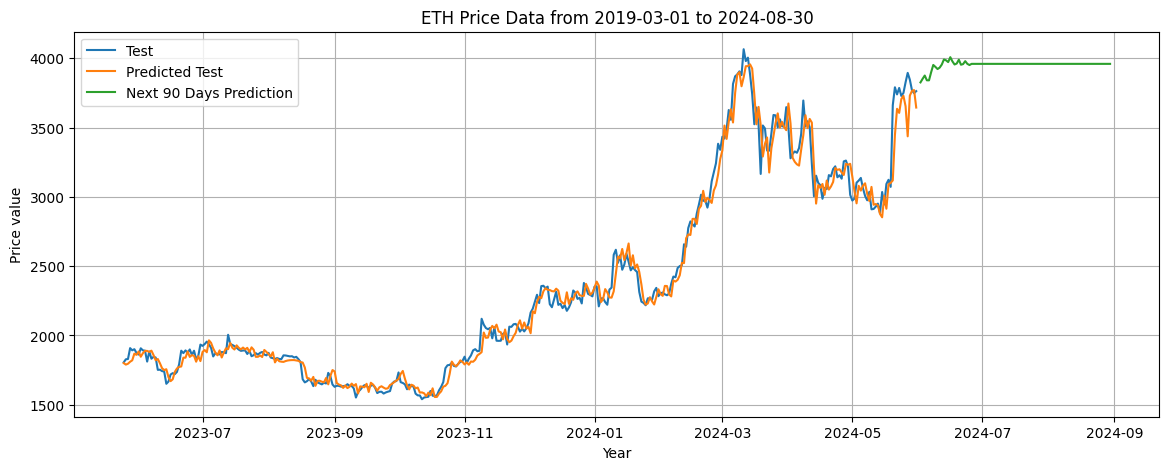

In [20]:
# Process of creating index to predict the next 90 days
last_index = len(df_Price) - 1

# Create an array of the last 'time_step' values from the dataset
x_input = data_scaled[last_index-time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Predict the closing prices for the next 90 days
lst_output = []
n_steps = time_step
i = 0
while(i < 90):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[-time_step:]).reshape(1, -1)
        yhat = model.predict(x_input)
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape(1, -1)
        yhat = model.predict(x_input)
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# Inverse transform the predicted values
y_next_90_days = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))

# Print the predicted closing prices for the next 60 days
print('Predicted ETH prices for the next 60 days:')
print(y_next_90_days.flatten())

# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)
# Create a list of indices starting from the next date for 90 days
index_next_90_days = pd.date_range(start=next_date, periods=90).tolist()

# Plotting
plt.figure(figsize=(14, 5))
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_test)], y_test, label='Test')
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_pred)], y_pred, label='Predicted Test')
plt.plot(index_next_90_days, y_next_90_days, label='Next 90 Days Prediction')
plt.legend()
plt.grid()
plt.title(f"ETH Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_90_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Year")
plt.ylabel("Price value")
plt.show()